In [1]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ROOTDIR_DATA = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
!git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
import sys 
sys.path.append("/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP/src")

Cloning into '/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 203 (delta 110), reused 152 (delta 59), pack-reused 0
Receiving objects: 100% (203/203), 41.36 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (110/110), done.


# Load original and corrupted data

## Cifar10

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePTB08U/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePTB08U/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


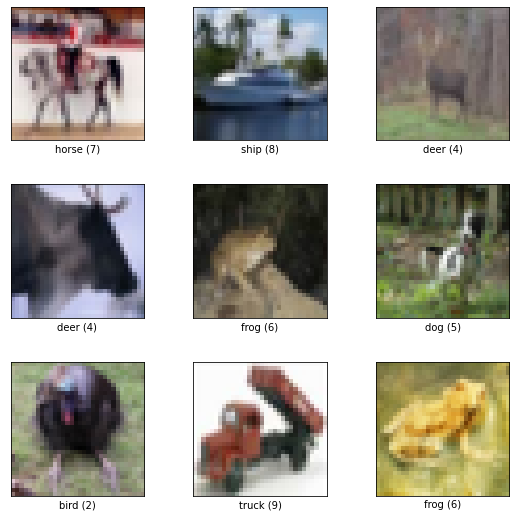

In [4]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 10, name='label', axis=-1)

(cifar10_train, cifar10_test), cifar10_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

fig = tfds.show_examples(cifar10_train, cifar10_info)

cifar10_train = cifar10_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.shuffle(cifar10_info.splits['train'].num_examples)
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
y_true_cifar10 = np.array([y.numpy() for x, y in cifar10_test])
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

## Corrupted dataset

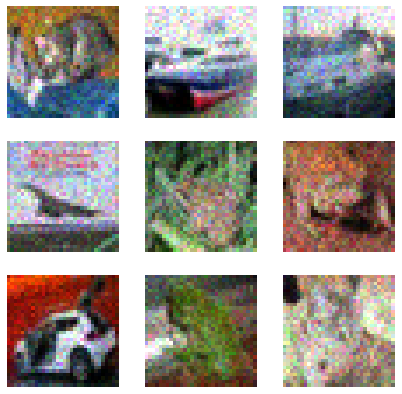

In [5]:
corruption_level = 3
corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/shot_noise.npy"))
corruption = corruption[corruption_level*10000:(corruption_level+1)*10000]
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy")
)[corruption_level*10000: (corruption_level+1)*10000]

corruption_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corruption))
fig, ax = plt.subplots(3, 3, figsize=(7, 7))
ax = ax.ravel()
j = 0
for x, y in corruption_ds.take(9):
    ax[j].imshow(x.numpy())
    ax[j].axis('off')
    j += 1
corruption_ds = corruption_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_ds = corruption_ds.cache()
corruption_ds = corruption_ds.batch(128)
corruption_ds = corruption_ds.prefetch(tf.data.AUTOTUNE)

# Load pre-trained CNN

In [6]:
from resnet import ResNet
input_shape = (32, 32, 3)
num_classes = 10
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

## Evaluate

In [7]:
results_cifar = model.evaluate(cifar10_test, verbose=0)
results_corruption = model.evaluate(corruption_ds, verbose=0)
print("Accuracy on cifar10 test set: {:.2f}".format(results_cifar[1]))
print("Accuracy on noisy cifar10 test set: {:.2f}".format(results_corruption[1]))

Accuracy on cifar10 test set: 0.83
Accuracy on noisy cifar10 test set: 0.36


In [8]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(repeat)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(repeat)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(repeat)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(repeat)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented


In [9]:
tta_model = TTAWrapper(model)

In [10]:
cifar10_many_preds = tta_model.predict_many_times(cifar10_test, "random_zoom", repeat=10)

In [11]:
corruption_many_preds = tta_model.predict_many_times(corruption_ds, "random_zoom", repeat=10)

## Plot uncertianties distributions

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


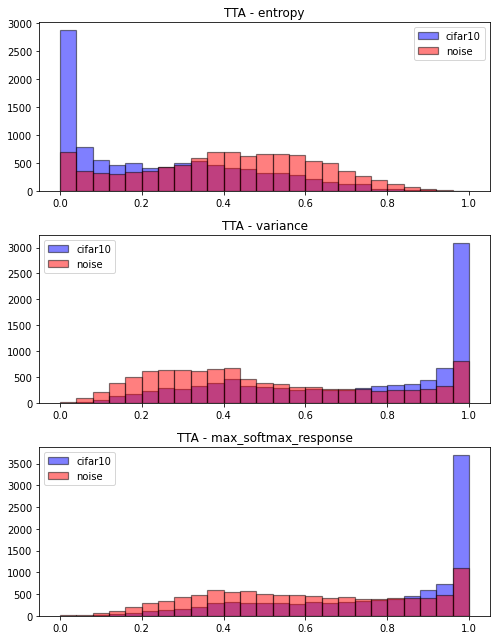

In [12]:
uncertainties_tta = dict()
uncertainties_tta['cifar10'] = (tta_model.uncertainty_metrics(np.array(cifar10_many_preds)), cifar10_many_preds, y_true_cifar10)
uncertainties_tta['corrupted'] = (tta_model.uncertainty_metrics(np.array(corruption_many_preds)), corruption_many_preds, label_corruption)
fig, axes = plt.subplots(len(tta_model._uncertainty_metrics.keys()), 1, figsize=(7, 9))
for ax, measure in zip(axes, tta_model._uncertainty_metrics.keys()):
    ax .set_title(f"TTA - {measure}")
    ax.hist(uncertainties_tta['cifar10'][0][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="cifar10");
    ax.hist(uncertainties_tta['corrupted'][0][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="noise");
    ax.legend()
plt.tight_layout()

# Risk-Coverage analysis

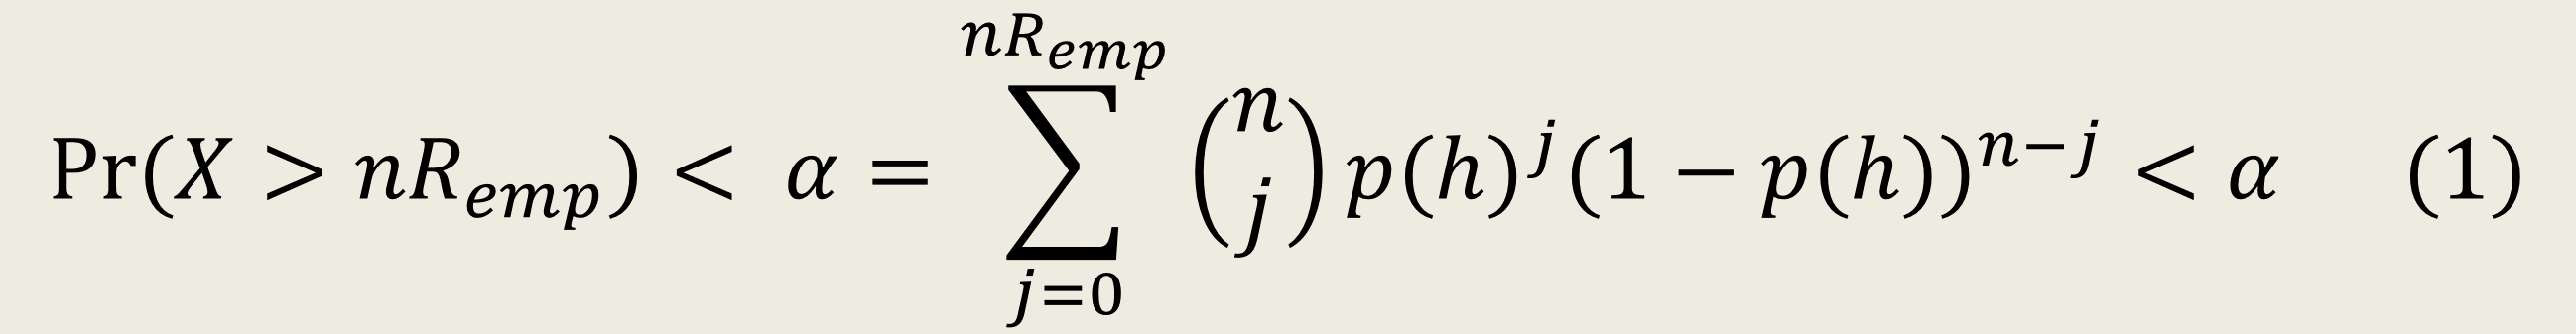

*   This means: **“We want the probability of observing more than $R_{𝑒𝑚𝑝}$ errors in n trials less than 𝛼”**
*   The inequation (1) depends on **p**, the **true risk**
*   Fixed the empirical risk, we evaluate which p ensures (1) by computing the cumulative density function of a binomial with parameters p, n, empirical risk 


In [13]:
import scipy
def get_risk_bound(n, r_emp, alpha=0.01):
    p_array = np.linspace(0, 1, 100)
    probabilities = np.array(
        [scipy.stats.binom.cdf(r_emp*n, n, p) for p in p_array])
    return p_array[np.where(probabilities < alpha)][0]

Now we can vary the empirical risk thanks to a selection function $𝑔_𝜃 (𝑥)$, based on a confidence measure 𝜅


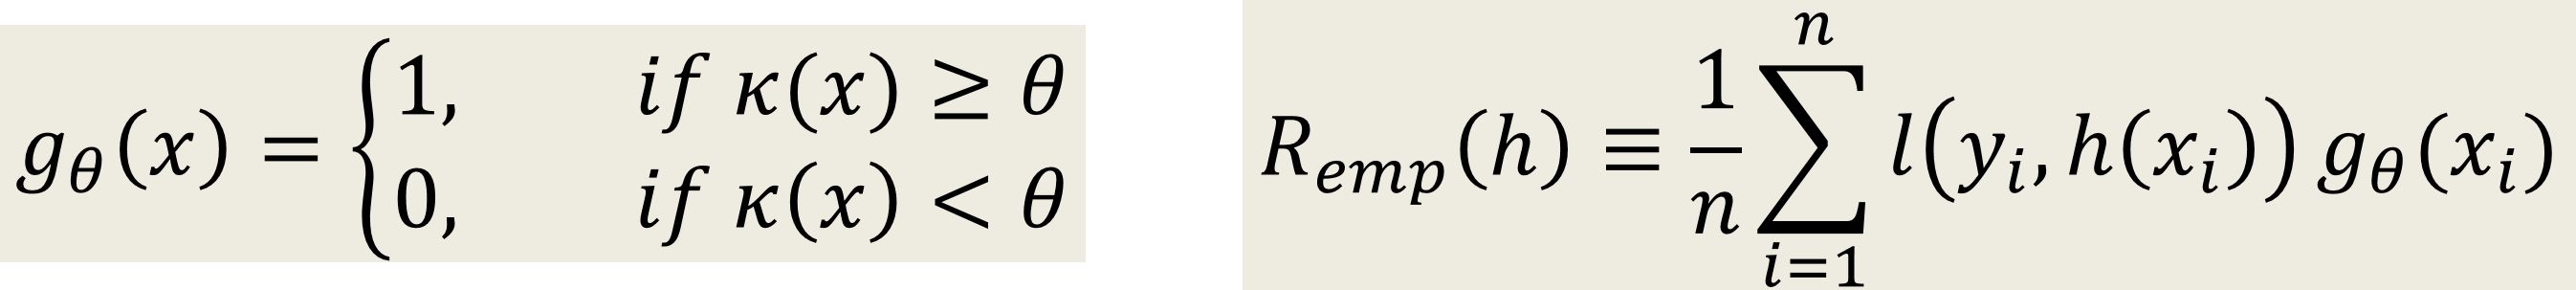

The empirical risk can be traded-off by coverage
*   Coverage is defined as the probability mass of the non-rejected region in X (i.e., the observed number of non-rejected samples)
*   That is, among all the classifiers satisfying $Pr⁡(𝑋>𝑛𝑅_{𝑒𝑚𝑝})< 𝛼$ the best one is that which maximize the coverage
*   The performance profile of the classifier can be specified by risk-coverage curves

Notably, **fixed an acceptable true risk 𝑅^∗, 𝛼, and 𝜅 we can obtain the threshold 𝜃 and the corresponding coverage**

In [14]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    thetas = np.array([_ for _ in np.linspace(0, 1, 10)])
    coverages = list()
    risk_bounds = list()
    for theta in thetas:
        try:
            inliers = y_pred[confidence_values > theta]
            inliers_lables = y_true[confidence_values > theta]
            errors = sum(inliers != inliers_lables)
            risk = errors / len(inliers)
            coverages.append(len(inliers) / len(y_pred))
            risk_bounds.append(get_risk_bound(n=len(inliers), 
                                              r_emp=risk, 
                                              alpha=alpha))
        except ZeroDivisionError:
            coverages.append(0)
            risk_bounds.append(0)
    risk_bounds = np.array(risk_bounds)
    indexes = risk_bounds == risk_bounds[risk_bounds <= r][0]
    if sum(indexes) > 1:
        first_true = np.where(indexes == True)[0][0]
        indexes = np.zeros(len(indexes), dtype=bool)
        indexes[first_true] = True
    return float(thetas[indexes]), float(np.array(coverages)[indexes]), float(risk_bounds[indexes])

In [15]:
# Create a mixed dataset
a = np.array([d[:7500] for d in cifar10_many_preds])
b = np.array([d[7500:] for d in corruption_many_preds])
uncertainties_tta['mixed'] = tta_model.uncertainty_metrics(np.concatenate((a, b), axis=1))
uncertainties_tta['mixed'] = (uncertainties_tta['mixed'], 
                              np.concatenate((a, b), axis=1),
                              np.concatenate((np.argmax(y_true_cifar10, axis=1)[:8000], label_corruption[8000:]), axis=0))

Done entropy
Done variance
Done max_softmax_response


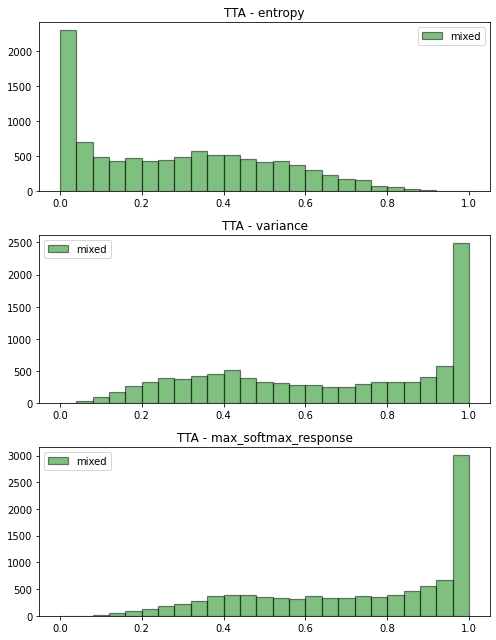

In [16]:
fig, axes = plt.subplots(len(tta_model._uncertainty_metrics.keys()), 1, figsize=(7, 9))
for ax, measure in zip(axes, tta_model._uncertainty_metrics.keys()):
    ax .set_title(f"TTA - {measure}")
    ax.hist(uncertainties_tta['mixed'][0][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mixed");
    ax.legend()
plt.tight_layout()

In [17]:
for dataset in uncertainties_tta.keys():
    print(dataset)
    y_true = uncertainties_tta[dataset][2]
    y_preds = uncertainties_tta[dataset][1]
    y_preds = np.mean(y_preds, axis=0)
    for measure_key in uncertainties_tta[dataset][0].keys():
        print(measure_key)
        if measure_key == 'entropy':
            measure = 1 - uncertainties_tta[dataset][0][measure_key]
        else:
            measure = uncertainties_tta[dataset][0][measure_key]
            
        (theta, coverage, risk_bound) = get_theta(y_preds,
                                                  y_true,
                                                  0.17, 
                                                  0.01, 
                                                  measure)
        print(coverage)

cifar10
entropy
0.893
variance
0.9428
max_softmax_response
0.9414
corrupted
entropy
0.0
variance
0.0
max_softmax_response
0.0
mixed
entropy
0.589
variance
0.6862
max_softmax_response
0.6267


# Explore all corruptions for all corruption level

In [ ]:
corruption_level = 1
n_samples = 200
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy"))
for filepath in glob.glob(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/*.npy")):
    corruption_type = os.path.basename(filepath).split('.')[0]
    if "labels" in corruption_type:
        continue
    corruption = np.load(filepath)
    random_indexes = np.random.choice(np.arange(corruption_level*10000, (corruption_level+1)*10000), n_samples)
    corruption = corruption[random_indexes]
    corruption_many_preds = tta_model.predict_many_times(cifar10_test, "random_zoom", repeat=10)
    uncertainties_tta[corruption_type] = (tta_model.uncertainty_metrics(np.array(corruption_many_preds)), 
                                          corruption_many_preds, 
                                          label_corruption[random_indexes])

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
